# SVD implementation

Implementation of recommender system using surprise SVD to study the effect of data sparsity on the system.

In [1]:
!pip3 install surprise
!pip install --upgrade numpy
!pip install recommenders[examples]

     |████████████████████████████████| 15.7 MB 9.5 MB/s eta 0:00:01     |█████████▋                      | 4.7 MB 10.3 MB/s eta 0:00:02
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.6.1 which is incompatible.
tensorflow 2.2.0rc1 requires tensorboard<2.2.0,>=2.1.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.2.0rc1 requires tensorflow-estimator<2.3.0,>=2.2.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.5 which is incompatible.


  Using cached numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.3 MB)


  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.6.1 which is incompatible.
tensorflow 2.2.0rc1 requires tensorboard<2.2.0,>=2.1.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.2.0rc1 requires tensorflow-estimator<2.3.0,>=2.2.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.


In [2]:
from surprise import SVD
from surprise import Dataset, accuracy, Reader

from surprise.model_selection import GridSearchCV
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
def _print(message, verbose):
    if verbose:
        print(message)
        
def load_dataset(data_f):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(data_f)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(data_f)
    return df

def filter_on_minimal_ratings(df):
    # Divide into preferred and non-preferred/not-seen
    df_preferred = df[df['rating'] > 3.5]
    df_low_rating = df[df['rating'] <= 3.5]

    # Keep users who clicked on at least 3 products
    df = min_rating_filter_pandas(df_preferred, min_rating=3, filter_by="user")

    # Keep products that were clicked on by at least on 1 user
    df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")
    df.reset_index(drop=True, inplace=True)
    return df, df_low_rating

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def split_dataframe(df, val_percentage=0.1, test_percentage=0.2):
    unique_users = sorted(df.userID.unique())
    np.random.seed(SEED)
    unique_users = np.random.permutation(unique_users)
    
    # Create train/validation/test users 
    n_users = len(unique_users)
    _print(f"Number of unique users: {n_users}")
    HELDOUT_USERS_VAL = int(val_percentage * n_users)
    HELDOUT_USERS_TEST = int(test_percentage * n_users)

    val_users = unique_users[:HELDOUT_USERS_VAL]
    _print(f"\nNumber of validation users: {len(val_users)}")

    test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
    _print(f"\nNumber of test users: {len(test_users)}")

    train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
    _print(f"\nNumber of training users: {len(train_users)}")
    
    # For training set keep only users that are in train_users list
    train_set = df.loc[df['userID'].isin(train_users)]
    _print(f"Number of training observations: {train_set.shape[0]}")

    # For validation set keep only users that are in val_users list
    val_set = df.loc[df['userID'].isin(val_users)]
    _print(f"\nNumber of validation observations: {val_set.shape[0]}")

    # For test set keep only users that are in test_users list
    test_set = df.loc[df['userID'].isin(test_users)]
    _print(f"\nNumber of test observations: {test_set.shape[0]}")

    # Obtain list of unique items used in training set
    unique_train_items = pd.unique(train_set['itemID'])
    _print(f"Number of unique items that rated in training set {unique_train_items.size}")
    
    # For validation set keep only items that used in training set
    val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
    _print(f"Number of validation observations after filtering: {val_set.shape[0]}")

    # For test set keep only items that used in training set
    test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
    _print(f"\nNumber of test observations after filtering: {test_set.shape[0]}")
    return train_set, val_set, test_set
    

def build_data(df):
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df, reader)
    return data

In [4]:
def data_loading_pipeline(fp, sparsity_percentage=None):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.

    output: trainset and testset 
    """
    df = load_dataset(fp)
    df = filter_to_sparsity(df, sparsity_percentage)
    train, test = python_random_split(df, 0.8)

    return train, test

### Simulation

In [5]:
"""Results dic will contain the values of the metric at different sparsities, the arrays
correspond to precision, recall, ndcg, etc."""
results = {0.75: [[], [], [], [], [], [], [], []],
           0.80: [[], [], [], [], [], [], [], []],
           0.85: [[], [], [], [], [], [], [], []],
           0.90: [[], [], [], [], [], [], [], []], 
           0.95: [[], [], [], [], [], [], [], []]}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [6]:
for spar in spt:     
    train, test = data_loading_pipeline("../data/AMAZON_FASHION_5.71.268.json", spar)
    
    reader = Reader(rating_scale=(1,5))
    train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

    param_grid = {'n_factors':[100,150,200],'n_epochs': [20,30,40,50,60,70,80]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
    gs.fit(train_set)
    
    for inter in range(20):
        np.random.seed(inter)

        sim_options = {'name': 'pearson_baseline', 'user_based': False }

        svd = SVD(n_factors =gs.best_params['rmse']['n_factors'],n_epochs=gs.best_params['rmse']['n_epochs'])
        trainset = train_set.build_full_trainset()
        svd.fit(trainset)

        predictions = predict(svd, test, usercol='userID', itemcol='itemID')

        with Timer() as test_time:
            all_predictions = compute_ranking_predictions(svd, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
        print("Took {} seconds for prediction.".format(test_time.interval))

        k=10

        
        precisions = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
        recalls = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)
        ndcg_val = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
        map_val = map_at_k(test, all_predictions, col_prediction='prediction', k=k)    
        eval_rmse = rmse(test, predictions)
        eval_mae = mae(test, predictions)
        eval_rsquared = rsquared(test, predictions)
        eval_exp_var = exp_var(test, predictions)
        
        results[round(spar,2)][0].append(precisions)
        results[round(spar,2)][1].append(recalls)
        results[round(spar,2)][2].append(ndcg_val)
        results[round(spar,2)][3].append(map_val)
        results[round(spar,2)][4].append(eval_rmse)
        results[round(spar,2)][5].append(eval_mae)
        results[round(spar,2)][6].append(eval_rsquared)
        results[round(spar,2)][7].append(eval_exp_var)

To obtain a sparsity of 75.0% we need to drop 391 ratings
Took 0.09525273600593209 seconds for prediction.
Took 0.0676525599847082 seconds for prediction.
Took 0.06354143400676548 seconds for prediction.
Took 0.06774665502598509 seconds for prediction.
Took 0.06628581599215977 seconds for prediction.
Took 0.07689683200442232 seconds for prediction.
Took 0.06763743699411862 seconds for prediction.
Took 0.11818399399635382 seconds for prediction.
Took 0.06404179500532337 seconds for prediction.
Took 0.06784863999928348 seconds for prediction.
Took 0.06390169498627074 seconds for prediction.
Took 0.06441782601177692 seconds for prediction.
Took 0.07324759699986316 seconds for prediction.
Took 0.07506994900177233 seconds for prediction.
Took 0.06922154501080513 seconds for prediction.
Took 0.06334615100058727 seconds for prediction.
Took 0.06574886201997288 seconds for prediction.
Took 0.11659873701864854 seconds for prediction.
Took 0.06528180098393932 seconds for prediction.
Took 0.06391

In [7]:
r_pres = []
r_recl = []
r_ndcg = []
r_maps = []
r_rmse = []
r_mae = []
r_rsquared = []
r_expvar = []
for i in results:
    r_pres.append(np.mean(results[i][0]))
    r_recl.append(np.mean(results[i][1]))
    r_ndcg.append(np.mean(results[i][2]))
    r_maps.append(np.mean(results[i][3]))
    r_rmse.append(np.mean(results[i][4]))
    r_mae.append(np.mean(results[i][5]))
    r_rsquared.append(np.mean(results[i][6]))
    r_expvar.append(np.mean(results[i][7]))

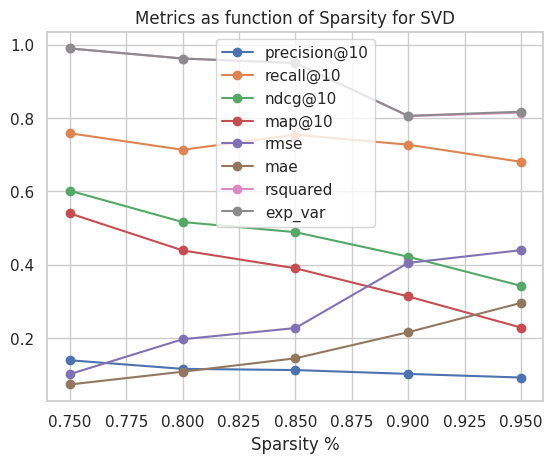

In [8]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")
plt.plot(spt,r_maps,label="map@10", marker = "o")
plt.plot(spt,r_rmse,label="rmse", marker = "o")
plt.plot(spt,r_mae,label="mae", marker = "o")
plt.plot(spt,r_rsquared,label="rsquared", marker = "o")
plt.plot(spt,r_expvar,label="exp_var", marker = "o")


plt.title("Metrics as function of Sparsity for SVD")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("../results/metrics_over_sparsity_svd.png")

plt.show()

In [9]:
import json

with open("../results/results_svd.json", "w") as op:
    json.dump(results, op)